In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# Загрузка данных из CSV файла
df = pd.read_csv('/home/jovyan/work/task3/Steel_industry_data.csv')

label_encoder = LabelEncoder()
df['WeekStatus'] = label_encoder.fit_transform(df['WeekStatus'])
df['Day_of_week'] = label_encoder.fit_transform(df['Day_of_week'])
df['Load_Type'] = label_encoder.fit_transform(df['Load_Type'])


# Предварительная обработка данных
# Преобразование даты в datetime и установка как индекса
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df.set_index('date', inplace=True)

# Добавление синусоидальных и косинусоидальных признаков для часов
df['hour_sin'] = np.sin(df.index.hour * (2. * np.pi / 24))
df['hour_cos'] = np.cos(df.index.hour * (2. * np.pi / 24))

# Добавление синусоидальных и косинусоидальных признаков для месяцев
df['month_sin'] = np.sin((df.index.month-1) * (2. * np.pi / 12))
df['month_cos'] = np.cos((df.index.month-1) * (2. * np.pi / 12))

df.reset_index(drop=True, inplace=True)
df = df.astype(float)

df = df.drop(['Day_of_week', 'WeekStatus'], axis=1)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  float64
 7   Load_Type                             35040 non-null  float64
 8   hour_sin                              35040 non-null  float64
 9   hour_cos                              35040 non-null  float64
 10  month_sin                             35040 non-null  float64
 11  month_cos      

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def initialize_weights(shape, scale=1.0):
    return np.random.randn(*shape) * np.sqrt(2. / (shape[0] + shape[1]))

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

class GRU:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Веса для ворот обновления (update gates)
        self.Wz = initialize_weights((input_size + hidden_size, hidden_size))
        self.bz = np.zeros((hidden_size,))
        
        # Веса для ворот сброса (reset gates)
        self.Wr = initialize_weights((input_size + hidden_size, hidden_size))
        self.br = np.zeros((hidden_size,))
        
        # Веса для кандидата на обновление скрытого состояния
        self.Wh = initialize_weights((input_size + hidden_size, hidden_size))
        self.bh = np.zeros((hidden_size,))
        
        # Веса для вывода
        self.V = initialize_weights((hidden_size, output_size))
        self.by = np.zeros((output_size,))
        
        self.h_prev = np.zeros((hidden_size,))

    def step_forward(self, x):
        z = np.hstack([x, self.h_prev])
        
        # Ворота обновления
        zt = sigmoid(np.dot(z, self.Wz) + self.bz)
        
        # Ворота сброса
        rt = sigmoid(np.dot(z, self.Wr) + self.br)
        
        # Кандидат на обновление скрытого состояния
        combined_r = np.hstack([x, rt * self.h_prev])
        ht_candidate = tanh(np.dot(combined_r, self.Wh) + self.bh)
        
        # Обновление скрытого состояния
        self.h_prev = zt * self.h_prev + (1 - zt) * ht_candidate
        
        y = np.dot(self.h_prev, self.V) + self.by
        return y

    def step_backward(self, x, dy, learning_rate):
        z = np.hstack([x, self.h_prev])
        
        # Ворота обновления и сброса
        zt = sigmoid(np.dot(z, self.Wz) + self.bz)
        rt = sigmoid(np.dot(z, self.Wr) + self.br)
        
        combined_r = np.hstack([x, rt * self.h_prev])
        ht_candidate = tanh(np.dot(combined_r, self.Wh) + self.bh)
        
        # Градиенты по выходу
        dh = np.dot(dy, self.V.T)
        
        dht_candidate = dh * (1 - zt) * (1 - ht_candidate**2)
        
        dWh = np.outer(combined_r, dht_candidate)
        dbh = dht_candidate
        
        drt = np.dot(dht_candidate, self.Wh.T[:, :self.hidden_size]) * rt * (1 - rt) * self.h_prev
        dWr = np.outer(z, drt)
        dbr = drt
        
        dzt = dh * (self.h_prev - ht_candidate) * zt * (1 - zt)
        dWz = np.outer(z, dzt)
        dbz = dzt
        
        # Обновление весов
        self.Wh -= learning_rate * dWh
        self.bh -= learning_rate * dbh
        self.Wr -= learning_rate * dWr
        self.br -= learning_rate * dbr
        self.Wz -= learning_rate * dWz
        self.bz -= learning_rate * dbz
        
        self.V -= learning_rate * np.outer(self.h_prev, dy)
        self.by -= learning_rate * dy

        # Обновление предыдущего скрытого состояния
        self.h_prev = zt * self.h_prev + (1 - zt) * tanh(np.dot(combined_r, self.Wh) + self.bh)

    def train(self, X_train, y_train, X_test, y_test, epochs=100, learning_rate=0.001, batch_size=16):
        for epoch in range(epochs):
            # Перемешивание индексов обучающего набора для создания мини-пакетов
            perm = np.random.permutation(len(X_train))
            train_losses = []
            
            # Итерация по мини-пакетам
            for i in range(0, len(X_train), batch_size):
                batch_indices = perm[i:i + batch_size]
                batch_x = X_train[batch_indices]
                batch_y = y_train[batch_indices]
    
                # Обучение на каждом мини-пакете
                for x, y_true in zip(batch_x, batch_y):
                    y_pred = self.step_forward(x)
                    dy = y_pred - y_true
                    self.step_backward(x, dy, learning_rate)
                    train_losses.append(mean_squared_error(y_true, y_pred))
    
            train_loss = np.mean(train_losses)
            
            # Валидация на тестовом наборе каждые 10 эпох
            if epoch % 10 == 0:
                test_losses = []
                for x, y_true in zip(X_test, y_test):
                    y_pred = self.step_forward(x)
                    loss = mean_squared_error(y_true, y_pred)
                    test_losses.append(loss)
                test_loss = np.mean(test_losses)
    
                print(f'Epoch {epoch}: Train Loss {train_loss:.4f}, Test Loss {test_loss:.4f}')
    
        print("Training complete.")


X = df.drop('Usage_kWh', axis=1).values
y = df['Usage_kWh'].values.reshape(-1, 1)

# Normalization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=True, random_state=42)

input_size = X_train.shape[1]
hidden_size = 10
output_size = 1
gru = GRU(input_size, hidden_size, output_size)

# Training the model
gru.train(X_train, y_train, X_test, y_test, epochs=120, learning_rate=0.0001, batch_size=16)


Epoch 0: Train Loss 0.6222, Test Loss 0.3978
Epoch 10: Train Loss 0.1483, Test Loss 0.1260
Epoch 20: Train Loss 0.0754, Test Loss 0.0734
Epoch 30: Train Loss 0.0621, Test Loss 0.0618
Epoch 40: Train Loss 0.0595, Test Loss 0.0609
Epoch 50: Train Loss 0.0598, Test Loss 0.0639
Epoch 60: Train Loss 0.0622, Test Loss 0.0685
Epoch 70: Train Loss 0.0644, Test Loss 0.0760
Epoch 80: Train Loss 0.0704, Test Loss 0.0895
Epoch 90: Train Loss 0.0796, Test Loss 0.1133
Epoch 100: Train Loss 0.0833, Test Loss 0.1395
Epoch 110: Train Loss 0.0844, Test Loss 0.1584
Training complete.


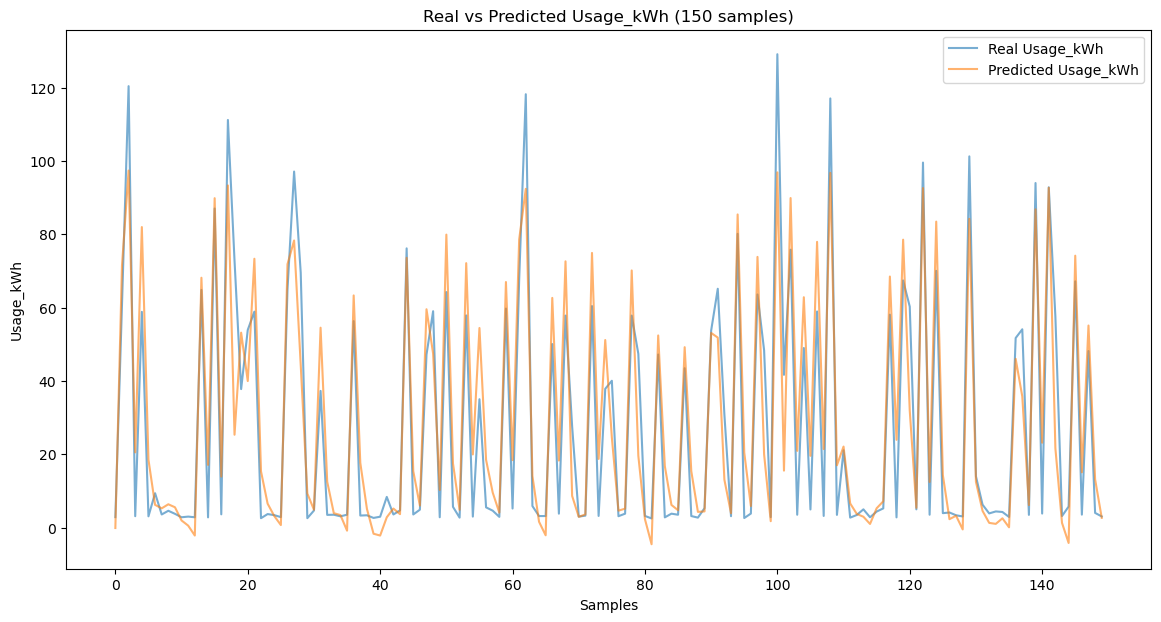

In [7]:
predictions = []
for x in X_test:
    pred = gru.step_forward(x)  # Убедитесь, что x уже в правильной форме
    predictions.append(pred)

# Поскольку результаты предсказаний будут двумерными из-за np.dot, нужно преобразовать их в одномерный массив
predictions = np.array(predictions).reshape(-1, 1)

# Обратное масштабирование предсказанных значений
y_test_inverse = scaler_y.inverse_transform(y_test)
predictions_inverse = scaler_y.inverse_transform(predictions)

# Построение графика для промежутка из 150 значений
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse[:150], label='Real Usage_kWh', alpha=0.6)
plt.plot(predictions_inverse[:150], label='Predicted Usage_kWh', alpha=0.6)
plt.xlabel('Samples')
plt.ylabel('Usage_kWh')
plt.title('Real vs Predicted Usage_kWh (150 samples)')
plt.legend()
plt.show()

Precision: 0.6453788179293931
Recall: 0.932111142938986
F1 Score: 0.7626860424235323
AUC: 0.9007602880211816


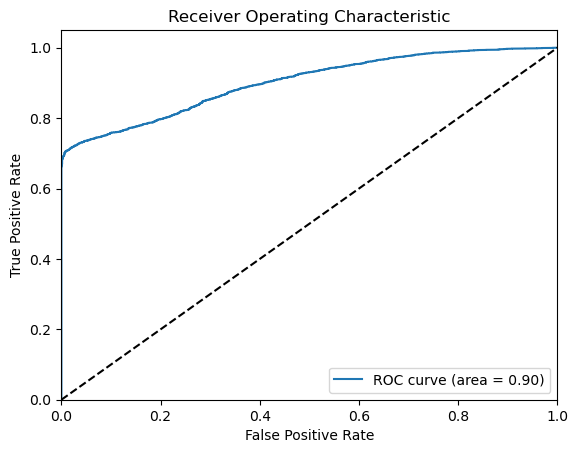

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Функции для вычисления метрик
def calculate_precision_recall_f1(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

def calculate_auc_roc(y_true, y_scores):
    # Сортируем значения по убыванию
    desc_score_indices = np.argsort(y_scores)[::-1]
    y_scores = y_scores[desc_score_indices]
    y_true = y_true[desc_score_indices]
    
    tpr_list = []
    fpr_list = []
    tp = 0
    fp = 0
    tn = np.sum(y_true == 0)
    fn = np.sum(y_true == 1)

    for i in range(len(y_scores)):
        if y_true[i] == 1:
            tp += 1
            fn -= 1
        else:
            fp += 1
            tn -= 1
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    auc = np.trapz(tpr_list, fpr_list)
    return auc, fpr_list, tpr_list

# Преобразование в бинарные метки на основе медианы
threshold = np.median(y_test_inverse)
y_test_binary = (y_test_inverse > threshold).astype(int)
predictions_binary = (predictions_inverse > threshold).astype(int)

# Вычисление метрик
precision, recall, f1 = calculate_precision_recall_f1(y_test_binary, predictions_binary)
auc, fpr, tpr = calculate_auc_roc(y_test_binary, predictions_inverse.ravel())

# Вывод метрик
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC: {auc}')

# Построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
